In [ ]:
!ls /content
!unzip intel-image-classification.zip -d /content/intel_dataset
from google.colab import files
files.upload()

In [2]:
import os

# Move kaggle.json to ~/.kaggle folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set proper permissions
!chmod 600 ~/.kaggle/kaggle.json

# Download the Intel Image Classification dataset
!kaggle datasets download -d puneet6060/intel-image-classification

# Unzip the dataset
!unzip intel-image-classification.zip -d /content/intel_dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7647.jpg  
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7652.jpg  
  inflating: /content/intel_dataset/seg_train/seg_train/mountain/7654.jpg  
  inflating: /content/intel_dataset/s

In [3]:
%%writefile data_loader.py
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split


def get_data_loaders(dataset_path, batch_size=128, num_workers=4, pin_memory=True,
                     train_split=0.7, val_split=0.15, test_split=0.15):
    """
    Load the Intel Image Classification dataset and create DataLoaders.

    Parameters:
        dataset_path (str): Path to the dataset (should point to the folder containing class subfolders).
        batch_size (int): Batch size for DataLoaders.
        train_split (float): Fraction of the dataset for training.
        val_split (float): Fraction of the dataset for validation.
        test_split (float): Fraction of the dataset for testing.

    Returns:
        train_loader, val_loader, test_loader (DataLoader): Data loaders for training, validation, and testing.
    """

    # Define transforms for training (data augmentation) and testing/validation (only resizing)
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the full dataset using ImageFolder
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(train_split * total_size)
    val_size = int(val_split * total_size)
    test_size = total_size - train_size - val_size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # For validation and test sets, apply the test_transforms
    val_dataset.dataset.transform = test_transforms
    test_dataset.dataset.transform = test_transforms

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader



Writing data_loader.py


In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 6  # Intel Image Classification has 6 categories

In [5]:
from data_loader import get_data_loaders
DATASET_PATH = "/content/intel_dataset"
train_loader, val_loader, test_loader = get_data_loaders(DATASET_PATH, batch_size=32)

In [6]:
class VGG16Model(nn.Module):
    def __init__(self, fine_tune=True):
        super(VGG16Model, self).__init__()
        self.model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)  # Load pretrained VGG-16
        self.model.classifier[6] = nn.Linear(4096, NUM_CLASSES)  # Modify the fully connected (FC) layer

        if not fine_tune:  # Freeze layers if fine_tune is False
            for param in self.model.features.parameters():
                param.requires_grad = False
            print(" VGG-16 loaded with frozen layers.")
        else:
            print(" VGG-16 loaded with full training.")

    def forward(self, x):
        return self.model(x)

In [7]:
def train_model(model, criterion, optimizer, num_epochs=25, scheduler=None, device='cuda'):
    train_losses, test_losses, train_accs, test_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        start_time = time.time()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()         # Reset gradients
            outputs = model(images)         # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()                 # Backward pass
            optimizer.step()                # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Evaluate on the test set
        test_loss, test_acc = evaluate_model(model, criterion, device=device)

        # Step the learning rate scheduler if provided
        if scheduler is not None:
            scheduler.step()

        epoch_time = time.time() - start_time

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% | "
              f"Time: {epoch_time:.2f}s")

    return train_losses, test_losses, train_accs, test_accs

In [8]:
def evaluate_model(model, criterion, device='cuda'):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total
    return test_loss, test_acc

In [9]:
def plot_metrics(train_losses, test_losses, train_accs, test_accs, model_name):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 92.7MB/s]


 VGG-16 loaded with full training.


Epoch 1/10: Train Loss: 0.9637, Train Acc: 56.86% | Test Loss: 0.9226, Test Acc: 58.53% | Time: 325.74s


Epoch 2/10: Train Loss: 0.9453, Train Acc: 57.56% | Test Loss: 0.9355, Test Acc: 58.53% | Time: 330.60s


Epoch 3/10: Train Loss: 0.9436, Train Acc: 57.53% | Test Loss: 0.9214, Test Acc: 58.53% | Time: 330.25s


Epoch 4/10: Train Loss: 0.9415, Train Acc: 57.55% | Test Loss: 0.9199, Test Acc: 58.53% | Time: 328.08s


Epoch 5/10: Train Loss: 0.9422, Train Acc: 57.55% | Test Loss: 0.9209, Test Acc: 58.53% | Time: 328.81s


Epoch 6/10: Train Loss: 0.9374, Train Acc: 57.55% | Test Loss: 0.9194, Test Acc: 58.53% | Time: 330.06s


Epoch 7/10: Train Loss: 0.9328, Train Acc: 57.55% | Test Loss: 0.9240, Test Acc: 58.53% | Time: 330.24s


Epoch 8/10: Train Loss: 0.9110, Train Acc: 57.60% | Test Loss: 0.9570, Test Acc: 57.49% | Time: 330.85s


Epoch 9/10: Train Loss: 0.8227, Train Acc: 60.85% | Test Loss: 1.0311, Test Acc: 53.99% | Time: 331.09s


Epoch 10/10: Train Loss: 0.6061, Train Acc: 72.63% | Test Loss: 1.3409, Test Acc: 49.74% | Time: 330.97s


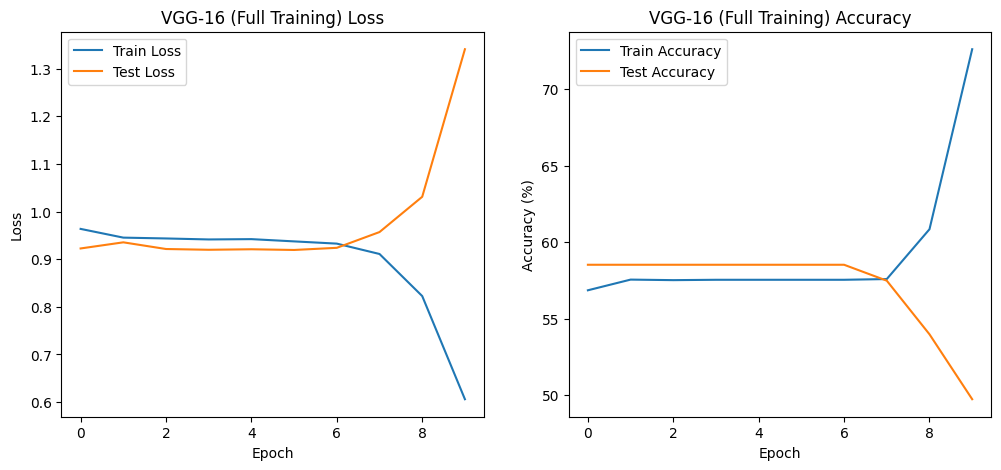

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model = VGG16Model(fine_tune=True).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer (e.g., Adam)
optimizer = optim.Adam(vgg16_model.parameters(), lr=0.0001)

# Define a learning rate scheduler (e.g., StepLR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train the model (adjust num_epochs as needed)
train_losses, test_losses, train_accs, test_accs = train_model(
    vgg16_model, criterion, optimizer, num_epochs=10, scheduler=scheduler, device=device
)

# Plot training and test metrics
plot_metrics(train_losses, test_losses, train_accs, test_accs, model_name="VGG-16 (Full Training)")


In [11]:
def evaluate_and_analyze(model, test_loader, device='cuda'):
    """
    Evaluate the model on the test set and compute:
      - Test Loss
      - Test Accuracy
      - Weighted F1-Score
      - Confusion Matrix
    """
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test F1 Score: {test_f1:.4f}")

    return test_loss, test_accuracy, test_f1, conf_matrix, all_labels, all_preds

In [12]:
def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plot the confusion matrix as a heatmap.

    Parameters:
        conf_matrix (array): Confusion matrix from sklearn.metrics.confusion_matrix.
        class_names (list): List of class labels.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 1.3409
Test Accuracy: 49.74%
Test F1 Score: 0.4709


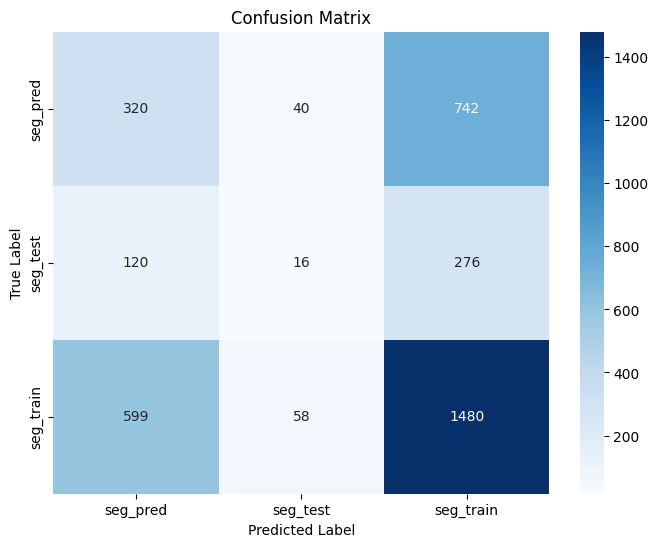

In [13]:
# Evaluate the model on the test set and compute metrics
test_loss, test_accuracy, test_f1, conf_matrix, true_labels, pred_labels = evaluate_and_analyze(vgg16_model, test_loader, device=device)

# Get class names (adjust based on how you load your dataset)
# For example, if you used ImageFolder, it might be:
class_names = train_loader.dataset.dataset.classes  # or similar depending on your data loader setup

# Plot the confusion matrix as a heatmap
plot_confusion_matrix(conf_matrix, class_names)